## Experimento 4. 
## Predicción de la movilidad ocupacional al regreso del último viaje migratorio

Este experimento se propone tomando como referencia principal el artículo "Occupational Mobility among Returned Migrants in Latin America: A Comparative Analysis". En este experimento se prentende analizar el potencial de mobilidad ocupacional en personas migrantes entre sus 25 y 45 años de edad.

Selección y limpieza de datos a partir de las tablas <b>LIFE</b> y <b>COMMUNITY</b>.

El dataset se forma a partir de la combinación de ambas tablas. Los atributos a utilizar para el análisis de mobilidad ocupacional son los propuestos por el autor del artículo referenciado.

El autor propone etiquetar el nivel ocupacional de las personas migrantes y no migrantes a partir de lo incluído en el MMP. Según el trabajo citado, la etiqueta de clase puede tomar cuatro valores posibles que clasifican el cambio ocupacional entre los 25 y 45 años de edad de una persona:<br>
1. Upward (en una categoría ocupacional mayor)
1. Downward (en una categoría ocupacional menor)
1. No movement (permanece en la misma categoría)
1. Undetermined (Dato perdido en la ocupación inicial o final)

Para predecir la mobilidad ocupacional, en el artículo oríginal se realizó el cálculo de varios modelos de regresión logística multinomial.
En este trabajo se propone realizar la misma tarea utilizando algoritmos de Machine Learning Supervisados para clasificación.

<br>

---

### Definición de clases

In [1]:
#Definición de clases

#{'downward': 0, 'upward': 1}

classes = [(0, 'downward'),(1,'no_movement'),(2,'upward')] #Clases negative (downward, no_movement)

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

### Añadir librerías necesarias

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tabulate import tabulate

sys.path.append(os.path.abspath(os.path.join('..'))) #Utils path
from tesis_experiments_utils import classifiers_utils as cu
from tesis_experiments_utils import confusion_matrices_utils as cmu
from tesis_experiments_utils import data_utils as du
from tesis_experiments_utils import files_utils as fu
from tesis_experiments_utils import learning_curves_utils as lcu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTENC

### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

Variables para la lectura del dataset

Crear carpetas para almacenamiento de los resultados, particiones de datos, etc.

In [3]:
fu.setup_folders()

La carpeta 'particiones/hold_out' ha sido creada
La carpeta 'datos_imputados' ha sido creada
La carpeta 'matrices_de_confusion' ha sido creada
La carpeta 'curvas_de_aprendizaje' ha sido creada
La carpeta 'resultados' ha sido creada


In [4]:
#Ubicación del dataset
path_to_data = os.path.join('..', 'datasets')
path_to_file = os.path.join(path_to_data,'movilidad_ocupacional', 'movilidad_ocupacional_encoded_labeled_THREE_CLASSES.csv')

#cat_atts = ['birth_cohort','age_us_experience', 'legal_status', 'latest_us_occupation', 'locality_type'] #Atributos categóricos
cat_atts = ['birth_cohort', 'legal_status', 'latest_us_occupation','education'] #Atributos categóricos
num_atts = ['labor_exp_age45','first_migration_age','total_trips','accumulated_us_experience','mean_proportion_low_income'] #Atributos numéricos

## Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

Realizar partición de datos con Hold-out

In [5]:
X_train, X_test, y_train, y_test = du.stratified_hold_out(path_to_file, cat_atts, test_size=0.2)
X = pd.concat([X_train, X_test])

Archivo 'X_train.csv' no encontrado en 'particiones/hold_out/0.80_0.20'
Generando una nueva partición de datos hold out 0.80-0.20. Almacenando en: 'particiones/hold_out/0.80_0.20'

Se ha generado y almacenado una nueva partición de datos en 'particiones/hold_out/0.80_0.20'


### K-fold Cross Validation

In [6]:
kf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

## Imputación de datos perdidos

In [7]:
X_train, X_test = du.impute_data(X_train, X_test, cat_atts,'median')

Archivo 'X_train_imputed_median.csv' no encontrado en 'datos_imputados'
Imputando valores faltantes en los conjuntos de datos utilizando la estrategia 'median'

Se han imputado y almacenado los conjuntos de datos en 'datos_imputados'


## Balanceo de clases

Cálculo de IR antes de aplicar SMOTEC

In [8]:
du.calculate_imbalance_ratio(y_train, classes)

Cardinalidades de las clases
Clase          Cardinalidad
-----------  --------------
downward                232
no_movement            1189
upward                  451
Dataset desbalanceado con IR = 5.1250


In [9]:
smote_nc  = SMOTENC(random_state=94, categorical_features=cat_atts) #SMOTENC
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

Cálculo de IR después de aplicar SMOTEC

In [10]:
du.calculate_imbalance_ratio(y_train, classes)

Cardinalidades de las clases
Clase          Cardinalidad
-----------  --------------
downward               1189
no_movement            1189
upward                 1189
Dataset balanceado con IR = 1.0000


## Normalización del dataset para utilizarlo con clasificadores basádos en métricas

Normalización de los atributos del dataset utilizando la forma:

$
    \Large z = \frac{(x-\mu)}{\sigma}
$

También conocida como z-score

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()) # type: ignore
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out()) # type: ignore

## One hot encoding sobre atributos categóricos para utilizarlo con clasificadores basados en reglas

In [12]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#pd.concat(atributos no categóricos, atributos categóricos codificados, nombre de columnas, axis)
X_train_encoded = pd.concat([X_train.drop(cat_atts, axis=1), 
                             pd.DataFrame(encoder.fit_transform(X_train[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_atts, axis=1),
                            pd.DataFrame(encoder.transform(X_test[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)

Medidas de desempeño para cross validation y learning curve

In [13]:
scoring = ['accuracy'] #Métricas de evaluación para selección de modelos
score_validation = 'accuracy' #Métrica de evaluación para learning curve

# Clasificadores k-NN

### **Elección del parámetro k**

Elección del parámetro k que minimiza el error de generalización utilizando *10-fold cross validation* a partir del Coeficiente de Correlación de Matthews.

In [14]:
k_range = range(1,52,2)
params = {'n_neighbors': k_range}

#Distancia de mahalanobis?
knn = KNeighborsClassifier()


best_knn = GridSearchCV(knn,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_knn.fit(X_train_scaled, y_train)
best_score = best_knn.best_score_
best_k = best_knn.best_params_['n_neighbors']

print(f'Mejor k: {best_k}, con bes_score media de {best_score:.4f} en validación cruzada.')

Fitting 10 folds for each of 26 candidates, totalling 260 fits
[CV 4/10] END ..........n_neighbors=1; accuracy: (test=0.591) total time=   0.0s
[CV 7/10] END ..........n_neighbors=3; accuracy: (test=0.597) total time=   0.0s
[CV 8/10] END ..........n_neighbors=3; accuracy: (test=0.590) total time=   0.0s
[CV 5/10] END ..........n_neighbors=1; accuracy: (test=0.639) total time=   0.0s
[CV 9/10] END ..........n_neighbors=3; accuracy: (test=0.643) total time=   0.0s
[CV 10/10] END .........n_neighbors=3; accuracy: (test=0.615) total time=   0.0s
[CV 1/10] END ..........n_neighbors=5; accuracy: (test=0.616) total time=   0.0s
[CV 2/10] END ..........n_neighbors=5; accuracy: (test=0.627) total time=   0.0s
[CV 3/10] END ..........n_neighbors=5; accuracy: (test=0.588) total time=   0.0s
[CV 4/10] END ..........n_neighbors=5; accuracy: (test=0.627) total time=   0.0s
[CV 2/10] END ..........n_neighbors=1; accuracy: (test=0.627) total time=   0.0s
[CV 5/10] END ..........n_neighbors=5; accurac

Archivo de curvas de aprendizaje creado en curvas_de_aprendizaje/curvas_de_aprendizaje.csv
Curvas de aprendizaje del clasificador 1-NN almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


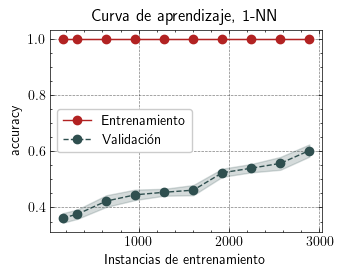

In [15]:
knn = KNeighborsClassifier(n_neighbors=best_k)
lcu.plot_and_save_learning_curve(knn, f'{best_k}-NN',X_train_scaled, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Archivo de resultados creado en resultados/resultados.csv
Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.476496           0.406516     0.275862     0.680921   
0   no_movement  0.476496           0.406516     0.545455     0.516949   
0        upward  0.476496           0.406516     0.398230     0.661710   
0     macro_avg  0.476496           0.406516     0.406516     0.619860   
0  weighted_avg  0.476496           0.406516     0.476496     0.572223   

         f1       mcc  
0  0.187135 -0.034211  
0  0.627907  0.056387  
0  0.361446  0.057134  
0  0.392162  0.026437  
0  0.50

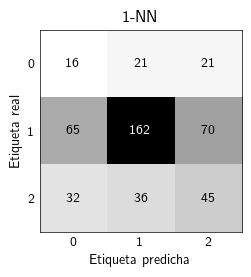

In [16]:
cu.train_and_evaluate_model_multiclass(knn, X_train_scaled, y_train, X_test_scaled, y_test, f'{best_k}-NN', classes)

### **Naïve Bayes**

Curvas de aprendizaje del clasificador Naïve Bayes almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


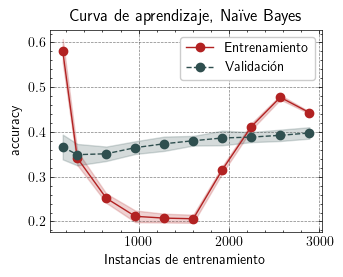

In [17]:
nb = GaussianNB()
lcu.plot_and_save_learning_curve(nb, 'Naïve Bayes',X_train_encoded, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.200855           0.379966     0.948276     0.105978   
0   no_movement  0.200855           0.379966     0.094276     0.857143   
0        upward  0.200855           0.379966     0.097345     0.709402   
0     macro_avg  0.200855           0.379966     0.379966     0.557508   
0  weighted_avg  0.200855           0.379966     0.200855     0.728377   

         f1       mcc  
0  0.248869  0.062414  
0  0.166667 -0.064274  
0  0.139241 -0.243538  
0  0.184925 -0.081799  
0  0.170232 -0.091857  


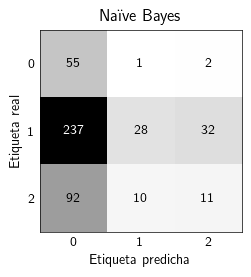

In [18]:
cu.train_and_evaluate_model_multiclass(nb, X_train_encoded, y_train, X_test_encoded, y_test, 'Naïve Bayes',classes)

# Decision Tree

In [19]:
depth_range = range(1,52)
params = {'max_depth': depth_range}
dtree = DecisionTreeClassifier()
best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_score = best_tree.best_score_
best_depth = best_tree.best_params_['max_depth']

print(f'Best Score: {best_score}, best depth: {best_depth}')

Fitting 10 folds for each of 51 candidates, totalling 510 fits
[CV 2/10] END ............max_depth=1; accuracy: (test=0.412) total time=   0.0s
[CV 4/10] END ............max_depth=1; accuracy: (test=0.370) total time=   0.0s
[CV 7/10] END ............max_depth=1; accuracy: (test=0.370) total time=   0.0s
[CV 8/10] END ............max_depth=1; accuracy: (test=0.376) total time=   0.0s
[CV 5/10] END ............max_depth=1; accuracy: (test=0.370) total time=   0.0s
[CV 1/10] END ............max_depth=1; accuracy: (test=0.378) total time=   0.0s
[CV 6/10] END ............max_depth=1; accuracy: (test=0.401) total time=   0.0s
[CV 3/10] END ............max_depth=1; accuracy: (test=0.361) total time=   0.0s
[CV 10/10] END ...........max_depth=1; accuracy: (test=0.410) total time=   0.0s
[CV 9/10] END ............max_depth=1; accuracy: (test=0.404) total time=   0.0s
[CV 4/10] END ............max_depth=2; accuracy: (test=0.403) total time=   0.0s[CV 3/10] END ............max_depth=2; accuracy

In [20]:
min_samples_split_range = range(2,41)
min_samples_leaf_range = range(1,21)
params = {'min_samples_split': min_samples_split_range, 'min_samples_leaf':min_samples_leaf_range}
dtree = DecisionTreeClassifier(max_depth=best_depth)

best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, return_train_score=False, verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_score = best_tree.best_score_
best_min_samples_split = best_tree.best_params_['min_samples_split']
best_min_samples_leaf = best_tree.best_params_['min_samples_leaf']

print(best_min_samples_split, best_min_samples_leaf)

Fitting 10 folds for each of 780 candidates, totalling 7800 fits
[CV 2/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.669) total time=   0.1s
[CV 3/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.630) total time=   0.1s
[CV 4/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.619) total time=   0.0s
[CV 5/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.622) total time=   0.1s
[CV 1/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.594) total time=   0.1s
[CV 6/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.616) total time=   0.1s
[CV 2/10] END min_samples_leaf=1, min_samples_split=3; accuracy: (test=0.647) total time=   0.0s[CV 1/10] END min_samples_leaf=1, min_samples_split=3; accuracy: (test=0.569) total time=   0.1s

[CV 7/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.608) total time=   0.1s
[CV 8/10] END min_samples_leaf=1, min_samples_split=2; accurac

In [21]:
best_min_samples_split, best_min_samples_leaf

(2, 1)

Curvas de aprendizaje del clasificador Decision Tree almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


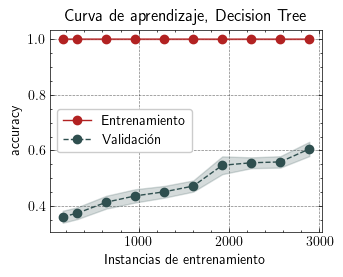

In [22]:
dtree = DecisionTreeClassifier(splitter="best", max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
lcu.plot_and_save_learning_curve(dtree, 'Decision Tree', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.465812           0.372521     0.258621     0.714789   
0   no_movement  0.465812           0.372521     0.575758     0.358779   
0        upward  0.465812           0.372521     0.283186     0.686347   
0     macro_avg  0.465812           0.372521     0.372521     0.586638   
0  weighted_avg  0.465812           0.372521     0.465812     0.481992   

         f1       mcc  
0  0.194805 -0.022207  
0  0.619565 -0.061478  
0  0.278261 -0.030165  
0  0.364210 -0.037950  
0  0.484515 -0.04905

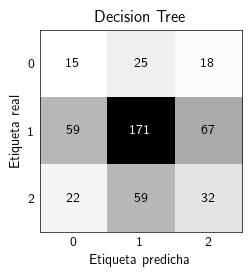

In [23]:
cu.train_and_evaluate_model_multiclass(dtree, X_train_encoded, y_train, X_test_encoded, y_test, 'Decision Tree',classes)

# Random Forest

In [24]:
rf = RandomForestClassifier(bootstrap=True, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
n_estimators_range = range(100,1100,100)
params = {'n_estimators': n_estimators_range}
best_rf = GridSearchCV(rf,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_rf.fit(X_train_encoded, y_train) 
best_score = best_tree.best_score_
best_n_estimators = best_rf.best_params_['n_estimators']

print(f'Best Score: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 4/10] END .......n_estimators=100; accuracy: (test=0.725) total time=   0.6s
[CV 3/10] END .......n_estimators=100; accuracy: (test=0.754) total time=   0.6s
[CV 2/10] END .......n_estimators=100; accuracy: (test=0.773) total time=   0.7s
[CV 5/10] END .......n_estimators=100; accuracy: (test=0.745) total time=   0.7s
[CV 7/10] END .......n_estimators=100; accuracy: (test=0.734) total time=   0.7s
[CV 6/10] END .......n_estimators=100; accuracy: (test=0.754) total time=   0.7s
[CV 1/10] END .......n_estimators=100; accuracy: (test=0.739) total time=   0.8s
[CV 10/10] END ......n_estimators=100; accuracy: (test=0.772) total time=   0.7s
[CV 9/10] END .......n_estimators=100; accuracy: (test=0.764) total time=   0.7s
[CV 8/10] END .......n_estimators=100; accuracy: (test=0.725) total time=   0.8s
[CV 4/10] END .......n_estimators=200; accuracy: (test=0.739) total time=   1.0s
[CV 1/10] END .......n_estimators=200; accurac

Curvas de aprendizaje del clasificador Random Forest almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


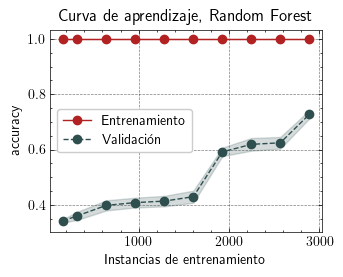

In [25]:
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
lcu.plot_and_save_learning_curve(rf, 'Random Forest', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.536325           0.371702     0.137931     0.826531   
0   no_movement  0.536325           0.371702     0.720539     0.274074   
0        upward  0.536325           0.371702     0.256637     0.765517   
0     macro_avg  0.536325           0.371702     0.371702     0.622041   
0  weighted_avg  0.536325           0.371702     0.536325     0.461201   

         f1       mcc  
0  0.136752 -0.035296  
0  0.702791 -0.005575  
0  0.276190  0.023278  
0  0.371911 -0.005864  
0  0.529637 -0.00229

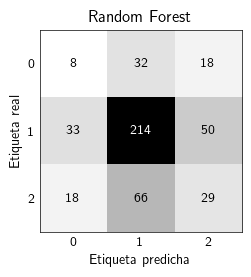

In [26]:
cu.train_and_evaluate_model_multiclass(rf, X_train_encoded, y_train, X_test_encoded, y_test, 'Random Forest', classes)

# Gradient Boosting Machine (GBM)

In [27]:
gbm =  GradientBoostingClassifier(criterion='friedman_mse')
n_estimators_range = range(1000,1500,100)
params = {'n_estimators': n_estimators_range}
best_gbm = GridSearchCV(gbm,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_gbm.fit(X_train_scaled, y_train) 
best_score = best_gbm.best_score_
best_n_estimators = best_gbm.best_params_['n_estimators']

print(f'Best Score: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 4/10] END ......n_estimators=1000; accuracy: (test=0.737) total time=  19.5s
[CV 3/10] END ......n_estimators=1000; accuracy: (test=0.773) total time=  19.9s
[CV 2/10] END ......n_estimators=1000; accuracy: (test=0.734) total time=  20.7s
[CV 5/10] END ......n_estimators=1000; accuracy: (test=0.725) total time=  20.8s
[CV 7/10] END ......n_estimators=1000; accuracy: (test=0.720) total time=  21.3s
[CV 9/10] END ......n_estimators=1000; accuracy: (test=0.730) total time=  21.4s
[CV 6/10] END ......n_estimators=1000; accuracy: (test=0.706) total time=  21.4s
[CV 10/10] END .....n_estimators=1000; accuracy: (test=0.758) total time=  21.7s
[CV 8/10] END ......n_estimators=1000; accuracy: (test=0.708) total time=  22.2s
[CV 6/10] END ......n_estimators=1100; accuracy: (test=0.706) total time=  22.7s
[CV 1/10] END ......n_estimators=1000; accuracy: (test=0.711) total time=  22.7s
[CV 1/10] END ......n_estimators=1100; accuracy:

Curvas de aprendizaje del clasificador GBM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


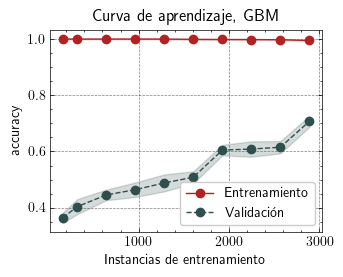

In [28]:
gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
lcu.plot_and_save_learning_curve(gbm, 'GBM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador GBM almacenados en resultados/resultados.csv
Resultados del clasificador GBM almacenados en resultados/resultados.csv
Resultados del clasificador GBM almacenados en resultados/resultados.csv
Resultados del clasificador GBM almacenados en resultados/resultados.csv
Resultados del clasificador GBM almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.576923           0.410556     0.189655     0.883959   
0   no_movement  0.576923           0.410556     0.767677     0.291667   
0        upward  0.576923           0.410556     0.274336     0.794020   
0     macro_avg  0.576923           0.410556     0.410556     0.656549   
0  weighted_avg  0.576923           0.410556     0.576923     0.486365   

         f1       mcc  
0  0.213592  0.081779  
0  0.727273  0.064123  
0  0.300971  0.072964  
0  0.413945  0.072955  
0  0.560680  0.068446  


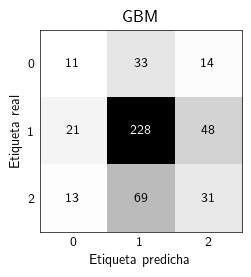

In [29]:
cu.train_and_evaluate_model_multiclass(gbm, X_train_scaled, y_train, X_test_scaled, y_test, 'GBM', classes)

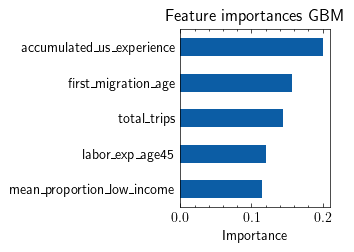

In [30]:
features=X_train_scaled.columns.to_list()
feature_imp = gbm.feature_importances_

df_feature_imp = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Feature importances GBM')
    ax.set_xlabel('Importance')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_gbm.png'), dpi=300, bbox_inches='tight')
plt.show()

# Multi Layer Perceptron (MLP)

In [31]:
mlp =  MLPClassifier(max_iter=1000, activation='relu', solver='sgd', learning_rate='adaptive', early_stopping=True)
hidden_layers_range = [(55,25),(55,30),(60,25),(60,30),(65,25),(65,30),(70,25),(70,30),(75,25),(75,30),(80,25),(80,30),
                       (85,25),(85,30),(90,25),(90,30),(95,25),(95,30),(100,25),(100,30)] #Número de neuronas en dos capas ocultas del MLP
#hidden_layers_range = [(100,20),(100,50),(200,20),(200,50),(300,20),(300,50),(400,20),(400,50),(500,20),(500,50)] #Número de neuronas en dos capas ocultas del MLP
params = {'hidden_layer_sizes': hidden_layers_range}
best_mlp = GridSearchCV(mlp,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation,verbose=3)
best_mlp.fit(X_train_scaled, y_train) 
best_score = best_mlp.best_score_
best_hidden_layers = best_mlp.best_params_['hidden_layer_sizes']

print(f'Best Score: {best_score}, best hidden layers: {best_hidden_layers}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 10/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.343) total time=   1.1s
[CV 5/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.303) total time=   1.1s
[CV 9/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.410) total time=   1.2s
[CV 4/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.412) total time=   1.5s
[CV 1/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.389) total time=   1.5s
[CV 2/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.459) total time=   1.6s
[CV 8/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.421) total time=   1.6s
[CV 6/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.499) total time=   1.7s
[CV 4/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.459) total time=   1.7s
[CV 5/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.459) total time=   1.8s
[CV 3/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.426) total time=   1.8s
[

Curvas de aprendizaje del clasificador MLP almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


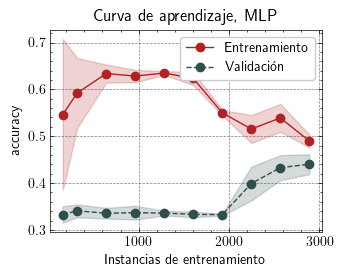

In [32]:
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation='relu', max_iter=2000, solver='sgd', learning_rate='adaptive', early_stopping=True)
lcu.plot_and_save_learning_curve(mlp, 'MLP', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador MLP almacenados en resultados/resultados.csv
Resultados del clasificador MLP almacenados en resultados/resultados.csv
Resultados del clasificador MLP almacenados en resultados/resultados.csv
Resultados del clasificador MLP almacenados en resultados/resultados.csv
Resultados del clasificador MLP almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.412393           0.353825     0.327586     0.583893   
0   no_movement  0.412393           0.353825     0.494949     0.418182   
0        upward  0.412393           0.353825     0.238938     0.656126   
0     macro_avg  0.412393           0.353825     0.353825     0.552734   
0  weighted_avg  0.412393           0.353825     0.412393     0.496171   

         f1       mcc  
0  0.189055 -0.066682  
0  0.578740 -0.077209  
0  0.237885 -0.104681  
0  0.335227 -0.082858  
0  0.448145 -0.082538  


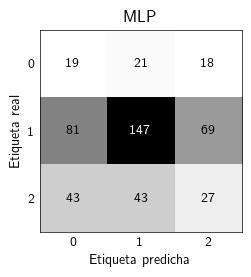

In [33]:
mlp.out_activation_ = 'multinomial'
cu.train_and_evaluate_model_multiclass(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP', classes)

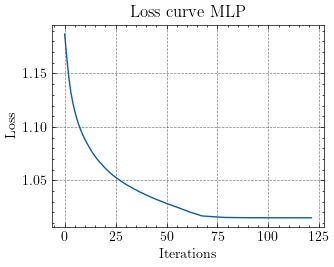

In [34]:
with plt.style.context(['science','grid']):
    fig, ax = plt.subplots()
    ax.plot(mlp.loss_curve_)
    ax.set_title('Loss curve MLP')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.savefig(os.path.join(fu.results_path,'MLP_loss_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Support Vector Machines (SVMs)

## SVM con kernel lineal

## SVM con kernel RBF Gaussiana

In [35]:
rsvm = SVC(kernel='rbf')
C_range = np.logspace(-3, 0, 7)
gamma_range = np.logspace(-3, 0, 7)
params = {'C': C_range, 'gamma': gamma_range}
best_rsvm = GridSearchCV(rsvm,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_rsvm.fit(X_train_scaled, y_train)
best_score = best_rsvm.best_score_
best_C = best_rsvm.best_params_['C']
best_gamma = best_rsvm.best_params_['gamma']
print(f'Best Score: {best_score}, best C: {best_C}, best gamma: {best_gamma}')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV 3/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.440) total time=   0.7s
[CV 4/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.381) total time=   0.7s
[CV 1/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.448) total time=   0.9s
[CV 9/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.331) total time=   1.0s
[CV 1/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.423) total time=   1.0s
[CV 8/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.331) total time=   1.0s
[CV 2/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.431) total time=   1.1s
[CV 7/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.459) total time=   1.1s
[CV 5/10] END ...C=0.001, gamma=0.001; accuracy: (test=0.445) total time=   1.1s
[CV 6/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.471) total time=   1.1s
[CV 4/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.395) total time=  

Curvas de aprendizaje del clasificador RBF SVM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


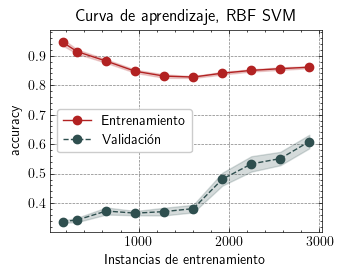

In [36]:
rsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
lcu.plot_and_save_learning_curve(rsvm, 'RBF SVM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv, n_jobs=-1, y_label=score_validation)

Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.514957           0.415752     0.275862     0.750000   
0   no_movement  0.514957           0.415752     0.626263     0.395683   
0        upward  0.514957           0.415752     0.345133     0.748148   
0     macro_avg  0.514957           0.415752     0.415752     0.631277   
0  weighted_avg  0.514957           0.415752     0.514957     0.524698   

         f1       mcc  
0  0.214765  0.021886  
0  0.656085  0.021062  
0  0.354545  0.094813  
0  0.408465  0.045920  
0  0.528584  0.038972  


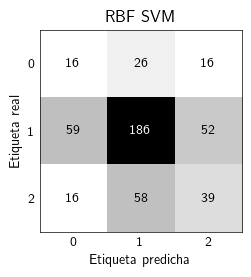

In [37]:
cu.train_and_evaluate_model_multiclass(rsvm, X_train_scaled, y_train, X_test_scaled, y_test, 'RBF SVM', classes)

# Regresión Logística

In [38]:
lr = LogisticRegression(max_iter=1000)
C_range = np.logspace(-3, 3, 7)
params = {'C': C_range}
best_lr = GridSearchCV(lr,params,scoring=scoring,cv=kf_cv,n_jobs=-1, refit =score_validation, verbose=3)
best_lr.fit(X_train_scaled, y_train)
best_score = best_lr.best_score_
best_C = best_lr.best_params_['C']
print(f'Best Score: {best_score}, best C: {best_C}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 3/10] END ................C=0.001; accuracy: (test=0.426) total time=   0.0s
[CV 1/10] END ................C=0.001; accuracy: (test=0.426) total time=   0.0s
[CV 4/10] END ................C=0.001; accuracy: (test=0.403) total time=   0.0s
[CV 2/10] END ................C=0.001; accuracy: (test=0.409) total time=   0.0s
[CV 5/10] END ................C=0.001; accuracy: (test=0.479) total time=   0.0s
[CV 6/10] END ................C=0.001; accuracy: (test=0.499) total time=   0.0s
[CV 7/10] END ................C=0.001; accuracy: (test=0.462) total time=   0.0s
[CV 10/10] END ...............C=0.001; accuracy: (test=0.478) total time=   0.0s
[CV 2/10] END .................C=0.01; accuracy: (test=0.395) total time=   0.0s[CV 9/10] END ................C=0.001; accuracy: (test=0.399) total time=   0.0s
[CV 3/10] END .................C=0.01; accuracy: (test=0.426) total time=   0.0s

[CV 1/10] END .................C=0.01; accuracy:

Curvas de aprendizaje del clasificador Logistic Regression almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


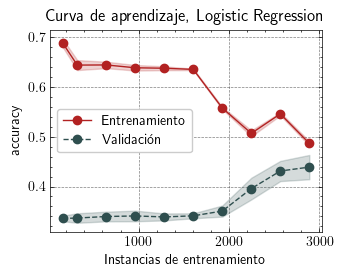

In [39]:
lr = LogisticRegression(C=best_C, max_iter=1000)
lcu.plot_and_save_learning_curve(lr, 'Logistic Regression', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv, y_label=score_validation)

Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
          clase  accuracy  balanced_accuracy  sensitivity  specificity  \
0      downward  0.416667           0.367034     0.327586     0.578947   
0   no_movement  0.416667           0.367034     0.481481     0.477064   
0        upward  0.416667           0.367034     0.292035     0.648000   
0     macro_avg  0.416667           0.367034     0.367034     0.568004   
0  weighted_avg  0.416667           0.367034     0.416667     0.530964   

         f1       mcc  
0  0.185366 -0.069812  
0  0.575453 -0.036746  
0  0.282051 -0.058898  
0  0.347623 -0

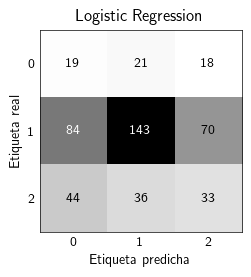

In [40]:
cu.train_and_evaluate_model_multiclass(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', classes)

# Resultados

In [41]:
#predicciones = pd.read_csv(os.path.join(fu.results_path,'predicciones.csv'))
#cmu.plot_save_all_conf_matrices(predicciones,[pos_class[0],neg_class[0]] ,[pos_class[1],neg_class[1]])

In [56]:
resultados = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'resultados.csv')))
resultados = resultados[resultados['clase']=='macro_avg'].sort_values(by=score_validation, ascending=False)
markdown_table = resultados.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)

| clasificador        | clase     |   accuracy |   balanced_accuracy |   sensitivity |   specificity |     f1 |     mcc |
|:--------------------|:----------|-----------:|--------------------:|--------------:|--------------:|-------:|--------:|
| GBM                 | macro_avg |     0.5769 |              0.4106 |        0.4106 |        0.6565 | 0.4139 |  0.0730 |
| Random Forest       | macro_avg |     0.5363 |              0.3717 |        0.3717 |        0.6220 | 0.3719 | -0.0059 |
| RBF SVM             | macro_avg |     0.5150 |              0.4158 |        0.4158 |        0.6313 | 0.4085 |  0.0459 |
| 1-NN                | macro_avg |     0.4765 |              0.4065 |        0.4065 |        0.6199 | 0.3922 |  0.0264 |
| Decision Tree       | macro_avg |     0.4658 |              0.3725 |        0.3725 |        0.5866 | 0.3642 | -0.0380 |
| Logistic Regression | macro_avg |     0.4167 |              0.3670 |        0.3670 |        0.5680 | 0.3476 | -0.0552 |
| MLP                 | 

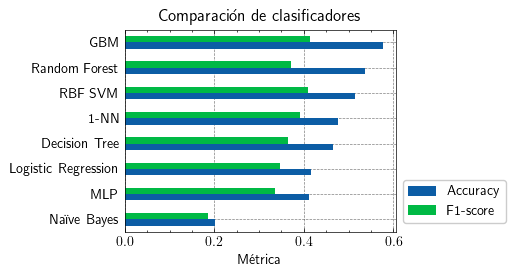

In [57]:
with plt.style.context(["science", "grid"]):
    ax = resultados.sort_values(by='accuracy').plot(kind="barh", x="clasificador", y=['accuracy', 'f1'])
    ax.set_title("Comparación de clasificadores")
    ax.set_xlabel("Métrica")
    ax.set_ylabel("")
    ax.legend(['Accuracy', 'F1-score'], loc="center left", bbox_to_anchor=(1.0, 0.15))
    ax.tick_params(axis="y", which="both", length=0)
fig = ax.get_figure()
fig.savefig(os.path.join('resultados', "scores.png"), dpi=300, bbox_inches="tight")
plt.show()

Learning curves de validación de todos los clasificadores

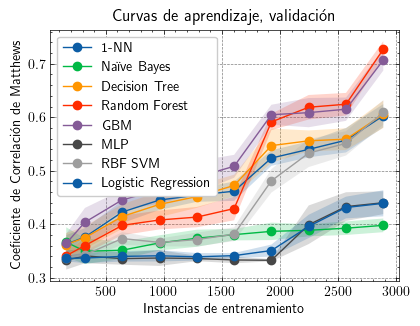

In [44]:
lcu.plot_and_save_all_learning_curves()